In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
import torch
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [32]:
from typing import List, Tuple

def load_train_data(
    positive_filepath: str,
    negative_filepath: str
) -> Tuple[List[str], List[int]]:
    """Load the training data, producing Lists of text and labels

    Args:
        filepath (str): Path to the training file

    Returns:
        Tuple[List[str], List[int]]: The texts and labels
    """

    def _read(filename: str):
        texts = []
        with open(filename,"r") as f:
            for line in f:
                _id, text = line.rstrip().split("\t")
                texts.append(text)

        return texts

    texts = []
    labels = []
    for text in _read(positive_filepath):
        texts.append(text)
        labels.append(1)

    for text in _read(negative_filepath):
        texts.append(text)
        labels.append(0)

    return texts, labels


def load_test_data(filepath: str) -> List[str]:
    """Load the test data, producing a List of texts

    Args:
        filepath (str): Path to the training file

    Returns:
        List[str]: The texts
    """
    texts = []
    labels = []
    with open(filepath, "r") as file:
        for line in file:
            idx, text, label = line.rstrip().split("\t")
            texts.append(text)
            if label == 'POS':
                label = 1
            else:
                label = 0
            labels.append(label)

    return texts, labels

In [33]:
# Q1

from collections import Counter

traintexts, trainlabels = load_train_data("/content/drive/MyDrive/A2/hotelPosT-train.txt", "/content/drive/MyDrive/A2/hotelNegT-train.txt")
testtexts, testlabels = load_test_data("/content/drive/MyDrive/A2/HW2-testset.txt")

count  = Counter(trainlabels)
print("Length of negative train samples", count[0])
print("Length of positive train samples", count[1])

Length of negative train samples 94
Length of positive train samples 95


In [34]:
# Q2

from sklearn.model_selection import train_test_split

train_texts, dev_texts, train_labels, dev_labels = train_test_split(traintexts, trainlabels, test_size=.2)
print(len(train_texts))
print(len(dev_texts))

151
38


In [35]:
# Q3

def precision(pred_labels, true_labels):
    true_positives, false_positives = 0, 0
    for pred, true in zip(pred_labels, true_labels):
        if pred == 1:
            if pred == true:
                true_positives += 1
            else:
                false_positives += 1
    return true_positives / (true_positives + false_positives)

def recall(pred_labels, true_labels):
    true_positives, false_negatives = 0, 0
    for pred, true in zip(pred_labels, true_labels):
        if true == 1:
            if pred == true:
                true_positives += 1
            else:
                false_negatives += 1
    return true_positives / (true_positives + false_negatives)

def f1(pred_labels, true_labels):
    p = precision(pred_labels, true_labels)
    r = recall(pred_labels, true_labels)
    return 2 * (p * r) / (p + r)

In [36]:
# Create hashsets for the three types of dictionaries

pronouns = {"I", "me", "my", "mine", "myself", "we", "us", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves"}

def read(filename: str):
  words = set()
  with open(filename,"r") as f:
    for line in f:
      arr = line.rstrip().split("\n")
      words.add(arr[0].lower())
  return words

positive_words = read("/content/drive/MyDrive/A2/positive-words.txt")
negative_words = read("/content/drive/MyDrive/A2/negative-words.txt")
print(len(positive_words))
print(len(negative_words))

2006
4780


In [37]:
# Q4

import re
import math

def featurize_text(text):
  vector = [0] * 6

  if len(text.split("!")) > 1:
    vector[4] = 1

  words = re.findall(r'\b[a-zA-Z]+\b', text)

  for word in words:
    if word.lower() in positive_words:
      vector[0] += 1
    if word.lower() in negative_words:
      vector[1] += 1
    if word == "I" or word.lower() in pronouns:
      vector[3] += 1
    if word.lower() == "no" and vector[2] == 0:
      vector[2] = 1

  vector[5] = math.log(len(words))
  return vector

# Q5

def findmaxmin(vectors):
  min_vals = np.min(vectors, axis=0)
  max_vals = np.max(vectors, axis=0)
  return max_vals, min_vals

def normalize(max_vals, min_vals, vectors):
  return (vectors - min_vals) / (max_vals - min_vals)

In [38]:
#Q6

class SentimentClassifier(torch.nn.Module):
    def __init__(self, input_dim: int = 6, output_size: int = 1):
        super(SentimentClassifier, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_size)

    def forward(self, feature_vec):
        z = self.linear(feature_vec)
        return torch.sigmoid(z)

    def logprob2label(self, log_prob):
        return log_prob.item() > 0.5

def train_model(model, train_vectors, train_labels, dev_vectors, dev_labels_tensor, num_epochs, batch_size, learning_rate = 0.1, verbose = False):
  loss_function = torch.nn.BCELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate )
  num_epochs = num_epochs
  batch_size = batch_size
  train_losses, dev_losses = [], []


  for epoch in range(num_epochs):
      samples = list(zip(train_vectors, train_labels))
      random.shuffle(samples)
      batches = [samples[i:i + batch_size] for i in range(0, len(samples), batch_size)]

      epoch_train_losses = []
      arg = None
      if verbose:
        arg = tqdm(batches, desc=f"Epoch {epoch+1}/{num_epochs}")
      else:
        arg = batches
      for batch in arg:
          feature_vectors, labels = zip(*batch)

          # Convert to tensors
          feature_vectors = torch.tensor(feature_vectors, dtype=torch.float32)
          labels = torch.tensor(labels, dtype=torch.float32).view(-1, 1)

          model.zero_grad()

          # Forward pass
          log_probs = model(feature_vectors)

          # Compute loss
          loss = loss_function(log_probs, labels)
          loss.backward()
          optimizer.step()

          # Store loss
          epoch_train_losses.append(loss.item())

      # Compute training loss for the epoch
      avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
      train_losses.append(avg_train_loss)

      # Validation phase
      model.eval()
      with torch.no_grad():
          dev_vectors_tensor = torch.tensor(dev_vectors, dtype=torch.float32)
          dev_preds = model(dev_vectors_tensor)
          dev_loss = loss_function(dev_preds, dev_labels_tensor).item()
          dev_losses.append(dev_loss)

      model.train()

      if verbose:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Avg train loss: {avg_train_loss:.4f} | Validation loss: {dev_loss:.4f}")
      else:
        if epoch + 1 == num_epochs:
          print(f"Epoch {epoch+1}/{num_epochs}")
          print(f"Avg train loss: {avg_train_loss:.4f} | Validation loss: {dev_loss:.4f}")

  print("-----------------------------------------\n")
  plt.figure(figsize=(8, 6))
  plt.plot(range(1, num_epochs+1), train_losses, label="Training Loss", marker='o')
  plt.plot(range(1, num_epochs+1), dev_losses, label="Validation Loss", marker='s')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Training vs Validation Loss")
  plt.legend()
  plt.grid()
  plt.show()

Epoch 1/100: 100%|██████████| 10/10 [00:00<00:00, 1051.70it/s]


Epoch 1/100
Avg train loss: 0.6903 | Validation loss: 0.6826


Epoch 2/100: 100%|██████████| 10/10 [00:00<00:00, 1143.24it/s]


Epoch 2/100
Avg train loss: 0.6662 | Validation loss: 0.6721


Epoch 3/100: 100%|██████████| 10/10 [00:00<00:00, 1157.43it/s]


Epoch 3/100
Avg train loss: 0.6566 | Validation loss: 0.6610


Epoch 4/100: 100%|██████████| 10/10 [00:00<00:00, 1158.58it/s]


Epoch 4/100
Avg train loss: 0.6512 | Validation loss: 0.6502


Epoch 5/100: 100%|██████████| 10/10 [00:00<00:00, 1178.74it/s]


Epoch 5/100
Avg train loss: 0.6403 | Validation loss: 0.6410


Epoch 6/100: 100%|██████████| 10/10 [00:00<00:00, 1104.05it/s]


Epoch 6/100
Avg train loss: 0.6310 | Validation loss: 0.6355


Epoch 7/100: 100%|██████████| 10/10 [00:00<00:00, 1129.66it/s]


Epoch 7/100
Avg train loss: 0.6312 | Validation loss: 0.6266


Epoch 8/100: 100%|██████████| 10/10 [00:00<00:00, 1205.92it/s]


Epoch 8/100
Avg train loss: 0.6160 | Validation loss: 0.6214


Epoch 9/100: 100%|██████████| 10/10 [00:00<00:00, 1126.23it/s]


Epoch 9/100
Avg train loss: 0.6158 | Validation loss: 0.6121


Epoch 10/100: 100%|██████████| 10/10 [00:00<00:00, 1260.91it/s]


Epoch 10/100
Avg train loss: 0.6069 | Validation loss: 0.6052


Epoch 11/100: 100%|██████████| 10/10 [00:00<00:00, 1296.78it/s]


Epoch 11/100
Avg train loss: 0.5988 | Validation loss: 0.5992


Epoch 12/100: 100%|██████████| 10/10 [00:00<00:00, 1234.93it/s]


Epoch 12/100
Avg train loss: 0.5934 | Validation loss: 0.5935


Epoch 13/100: 100%|██████████| 10/10 [00:00<00:00, 1033.77it/s]


Epoch 13/100
Avg train loss: 0.5869 | Validation loss: 0.5882


Epoch 14/100: 100%|██████████| 10/10 [00:00<00:00, 1198.89it/s]


Epoch 14/100
Avg train loss: 0.5834 | Validation loss: 0.5831


Epoch 15/100: 100%|██████████| 10/10 [00:00<00:00, 1041.49it/s]


Epoch 15/100
Avg train loss: 0.5762 | Validation loss: 0.5786


Epoch 16/100: 100%|██████████| 10/10 [00:00<00:00, 1041.88it/s]


Epoch 16/100
Avg train loss: 0.5709 | Validation loss: 0.5726


Epoch 17/100: 100%|██████████| 10/10 [00:00<00:00, 916.55it/s]


Epoch 17/100
Avg train loss: 0.5665 | Validation loss: 0.5676


Epoch 18/100: 100%|██████████| 10/10 [00:00<00:00, 1025.45it/s]


Epoch 18/100
Avg train loss: 0.5684 | Validation loss: 0.5641


Epoch 19/100: 100%|██████████| 10/10 [00:00<00:00, 890.38it/s]


Epoch 19/100
Avg train loss: 0.5634 | Validation loss: 0.5598


Epoch 20/100: 100%|██████████| 10/10 [00:00<00:00, 1179.00it/s]


Epoch 20/100
Avg train loss: 0.5481 | Validation loss: 0.5560


Epoch 21/100: 100%|██████████| 10/10 [00:00<00:00, 1144.39it/s]


Epoch 21/100
Avg train loss: 0.5461 | Validation loss: 0.5521


Epoch 22/100: 100%|██████████| 10/10 [00:00<00:00, 1244.42it/s]


Epoch 22/100
Avg train loss: 0.5446 | Validation loss: 0.5485


Epoch 23/100: 100%|██████████| 10/10 [00:00<00:00, 1358.44it/s]


Epoch 23/100
Avg train loss: 0.5412 | Validation loss: 0.5442


Epoch 24/100: 100%|██████████| 10/10 [00:00<00:00, 1398.33it/s]


Epoch 24/100
Avg train loss: 0.5291 | Validation loss: 0.5408


Epoch 25/100: 100%|██████████| 10/10 [00:00<00:00, 1467.41it/s]


Epoch 25/100
Avg train loss: 0.5287 | Validation loss: 0.5377


Epoch 26/100: 100%|██████████| 10/10 [00:00<00:00, 1382.43it/s]


Epoch 26/100
Avg train loss: 0.5333 | Validation loss: 0.5332


Epoch 27/100: 100%|██████████| 10/10 [00:00<00:00, 1455.60it/s]


Epoch 27/100
Avg train loss: 0.5253 | Validation loss: 0.5301


Epoch 28/100: 100%|██████████| 10/10 [00:00<00:00, 1127.96it/s]


Epoch 28/100
Avg train loss: 0.5190 | Validation loss: 0.5262


Epoch 29/100: 100%|██████████| 10/10 [00:00<00:00, 1256.42it/s]


Epoch 29/100
Avg train loss: 0.5149 | Validation loss: 0.5228


Epoch 30/100: 100%|██████████| 10/10 [00:00<00:00, 1192.31it/s]


Epoch 30/100
Avg train loss: 0.5221 | Validation loss: 0.5199


Epoch 31/100: 100%|██████████| 10/10 [00:00<00:00, 1098.96it/s]


Epoch 31/100
Avg train loss: 0.5068 | Validation loss: 0.5171


Epoch 32/100: 100%|██████████| 10/10 [00:00<00:00, 1094.20it/s]


Epoch 32/100
Avg train loss: 0.5059 | Validation loss: 0.5141


Epoch 33/100: 100%|██████████| 10/10 [00:00<00:00, 1036.42it/s]


Epoch 33/100
Avg train loss: 0.4971 | Validation loss: 0.5111


Epoch 34/100: 100%|██████████| 10/10 [00:00<00:00, 935.23it/s]


Epoch 34/100
Avg train loss: 0.4966 | Validation loss: 0.5084


Epoch 35/100: 100%|██████████| 10/10 [00:00<00:00, 1227.88it/s]


Epoch 35/100
Avg train loss: 0.4994 | Validation loss: 0.5057


Epoch 36/100: 100%|██████████| 10/10 [00:00<00:00, 1136.76it/s]


Epoch 36/100
Avg train loss: 0.4890 | Validation loss: 0.5036


Epoch 37/100: 100%|██████████| 10/10 [00:00<00:00, 634.56it/s]


Epoch 37/100
Avg train loss: 0.4868 | Validation loss: 0.5003


Epoch 38/100: 100%|██████████| 10/10 [00:00<00:00, 1093.69it/s]


Epoch 38/100
Avg train loss: 0.4837 | Validation loss: 0.4980


Epoch 39/100: 100%|██████████| 10/10 [00:00<00:00, 863.93it/s]


Epoch 39/100
Avg train loss: 0.4875 | Validation loss: 0.4958


Epoch 40/100: 100%|██████████| 10/10 [00:00<00:00, 755.28it/s]


Epoch 40/100
Avg train loss: 0.4796 | Validation loss: 0.4930


Epoch 41/100: 100%|██████████| 10/10 [00:00<00:00, 809.06it/s]


Epoch 41/100
Avg train loss: 0.4690 | Validation loss: 0.4906


Epoch 42/100: 100%|██████████| 10/10 [00:00<00:00, 812.02it/s]


Epoch 42/100
Avg train loss: 0.4721 | Validation loss: 0.4884


Epoch 43/100: 100%|██████████| 10/10 [00:00<00:00, 743.64it/s]


Epoch 43/100
Avg train loss: 0.4717 | Validation loss: 0.4860


Epoch 44/100: 100%|██████████| 10/10 [00:00<00:00, 869.20it/s]


Epoch 44/100
Avg train loss: 0.4699 | Validation loss: 0.4841


Epoch 45/100: 100%|██████████| 10/10 [00:00<00:00, 764.74it/s]


Epoch 45/100
Avg train loss: 0.4717 | Validation loss: 0.4820


Epoch 46/100: 100%|██████████| 10/10 [00:00<00:00, 557.61it/s]


Epoch 46/100
Avg train loss: 0.4597 | Validation loss: 0.4798


Epoch 47/100: 100%|██████████| 10/10 [00:00<00:00, 591.35it/s]


Epoch 47/100
Avg train loss: 0.4607 | Validation loss: 0.4780


Epoch 48/100: 100%|██████████| 10/10 [00:00<00:00, 538.82it/s]


Epoch 48/100
Avg train loss: 0.4596 | Validation loss: 0.4762


Epoch 49/100: 100%|██████████| 10/10 [00:00<00:00, 1150.67it/s]


Epoch 49/100
Avg train loss: 0.4531 | Validation loss: 0.4739


Epoch 50/100: 100%|██████████| 10/10 [00:00<00:00, 711.18it/s]

Epoch 50/100


Avg train loss: 0.4598 | Validation loss: 0.4717


Epoch 51/100: 100%|██████████| 10/10 [00:00<00:00, 907.31it/s]


Epoch 51/100
Avg train loss: 0.4513 | Validation loss: 0.4701


Epoch 52/100: 100%|██████████| 10/10 [00:00<00:00, 940.32it/s]


Epoch 52/100
Avg train loss: 0.4469 | Validation loss: 0.4686


Epoch 53/100: 100%|██████████| 10/10 [00:00<00:00, 1118.18it/s]


Epoch 53/100
Avg train loss: 0.4457 | Validation loss: 0.4665


Epoch 54/100: 100%|██████████| 10/10 [00:00<00:00, 1178.37it/s]


Epoch 54/100
Avg train loss: 0.4483 | Validation loss: 0.4647


Epoch 55/100: 100%|██████████| 10/10 [00:00<00:00, 993.46it/s]


Epoch 55/100
Avg train loss: 0.4424 | Validation loss: 0.4630


Epoch 56/100: 100%|██████████| 10/10 [00:00<00:00, 959.22it/s]


Epoch 56/100
Avg train loss: 0.4408 | Validation loss: 0.4612


Epoch 57/100: 100%|██████████| 10/10 [00:00<00:00, 1081.87it/s]


Epoch 57/100
Avg train loss: 0.4287 | Validation loss: 0.4594


Epoch 58/100: 100%|██████████| 10/10 [00:00<00:00, 1003.06it/s]


Epoch 58/100
Avg train loss: 0.4350 | Validation loss: 0.4578


Epoch 59/100: 100%|██████████| 10/10 [00:00<00:00, 768.78it/s]


Epoch 59/100
Avg train loss: 0.4301 | Validation loss: 0.4562


Epoch 60/100: 100%|██████████| 10/10 [00:00<00:00, 856.75it/s]

Epoch 60/100


Avg train loss: 0.4308 | Validation loss: 0.4549


Epoch 61/100: 100%|██████████| 10/10 [00:00<00:00, 827.82it/s]


Epoch 61/100
Avg train loss: 0.4367 | Validation loss: 0.4535


Epoch 62/100: 100%|██████████| 10/10 [00:00<00:00, 855.40it/s]


Epoch 62/100
Avg train loss: 0.4326 | Validation loss: 0.4518


Epoch 63/100: 100%|██████████| 10/10 [00:00<00:00, 780.12it/s]


Epoch 63/100
Avg train loss: 0.4314 | Validation loss: 0.4506


Epoch 64/100: 100%|██████████| 10/10 [00:00<00:00, 624.67it/s]


Epoch 64/100
Avg train loss: 0.4195 | Validation loss: 0.4493


Epoch 65/100: 100%|██████████| 10/10 [00:00<00:00, 773.71it/s]


Epoch 65/100
Avg train loss: 0.4232 | Validation loss: 0.4482


Epoch 66/100: 100%|██████████| 10/10 [00:00<00:00, 755.96it/s]


Epoch 66/100
Avg train loss: 0.4258 | Validation loss: 0.4468


Epoch 67/100: 100%|██████████| 10/10 [00:00<00:00, 967.79it/s]

Epoch 67/100


Avg train loss: 0.4275 | Validation loss: 0.4452


Epoch 68/100: 100%|██████████| 10/10 [00:00<00:00, 893.32it/s]


Epoch 68/100
Avg train loss: 0.4199 | Validation loss: 0.4435


Epoch 69/100: 100%|██████████| 10/10 [00:00<00:00, 686.42it/s]


Epoch 69/100
Avg train loss: 0.4190 | Validation loss: 0.4425


Epoch 70/100: 100%|██████████| 10/10 [00:00<00:00, 832.37it/s]


Epoch 70/100
Avg train loss: 0.4061 | Validation loss: 0.4413


Epoch 71/100: 100%|██████████| 10/10 [00:00<00:00, 1119.29it/s]


Epoch 71/100
Avg train loss: 0.4057 | Validation loss: 0.4402


Epoch 72/100: 100%|██████████| 10/10 [00:00<00:00, 726.11it/s]


Epoch 72/100
Avg train loss: 0.4189 | Validation loss: 0.4390


Epoch 73/100: 100%|██████████| 10/10 [00:00<00:00, 1011.16it/s]


Epoch 73/100
Avg train loss: 0.4067 | Validation loss: 0.4380


Epoch 74/100: 100%|██████████| 10/10 [00:00<00:00, 842.06it/s]


Epoch 74/100
Avg train loss: 0.4054 | Validation loss: 0.4370


Epoch 75/100: 100%|██████████| 10/10 [00:00<00:00, 810.62it/s]


Epoch 75/100
Avg train loss: 0.3973 | Validation loss: 0.4356


Epoch 76/100: 100%|██████████| 10/10 [00:00<00:00, 992.41it/s]


Epoch 76/100
Avg train loss: 0.4059 | Validation loss: 0.4343


Epoch 77/100: 100%|██████████| 10/10 [00:00<00:00, 972.64it/s]


Epoch 77/100
Avg train loss: 0.4067 | Validation loss: 0.4332


Epoch 78/100: 100%|██████████| 10/10 [00:00<00:00, 864.89it/s]


Epoch 78/100
Avg train loss: 0.3970 | Validation loss: 0.4322


Epoch 79/100: 100%|██████████| 10/10 [00:00<00:00, 793.16it/s]


Epoch 79/100
Avg train loss: 0.4061 | Validation loss: 0.4312


Epoch 80/100: 100%|██████████| 10/10 [00:00<00:00, 658.11it/s]


Epoch 80/100
Avg train loss: 0.4049 | Validation loss: 0.4297


Epoch 81/100: 100%|██████████| 10/10 [00:00<00:00, 956.84it/s]


Epoch 81/100
Avg train loss: 0.3931 | Validation loss: 0.4288


Epoch 82/100: 100%|██████████| 10/10 [00:00<00:00, 522.32it/s]


Epoch 82/100
Avg train loss: 0.3915 | Validation loss: 0.4279


Epoch 83/100: 100%|██████████| 10/10 [00:00<00:00, 852.83it/s]


Epoch 83/100
Avg train loss: 0.3953 | Validation loss: 0.4267


Epoch 84/100: 100%|██████████| 10/10 [00:00<00:00, 837.32it/s]


Epoch 84/100
Avg train loss: 0.3907 | Validation loss: 0.4255


Epoch 85/100: 100%|██████████| 10/10 [00:00<00:00, 1030.64it/s]


Epoch 85/100
Avg train loss: 0.3888 | Validation loss: 0.4246


Epoch 86/100: 100%|██████████| 10/10 [00:00<00:00, 1207.62it/s]


Epoch 86/100
Avg train loss: 0.4031 | Validation loss: 0.4236


Epoch 87/100: 100%|██████████| 10/10 [00:00<00:00, 665.92it/s]


Epoch 87/100
Avg train loss: 0.4007 | Validation loss: 0.4230


Epoch 88/100: 100%|██████████| 10/10 [00:00<00:00, 777.14it/s]


Epoch 88/100
Avg train loss: 0.3884 | Validation loss: 0.4219


Epoch 89/100: 100%|██████████| 10/10 [00:00<00:00, 885.51it/s]


Epoch 89/100
Avg train loss: 0.3849 | Validation loss: 0.4210


Epoch 90/100: 100%|██████████| 10/10 [00:00<00:00, 774.66it/s]


Epoch 90/100
Avg train loss: 0.3855 | Validation loss: 0.4201


Epoch 91/100: 100%|██████████| 10/10 [00:00<00:00, 1136.02it/s]


Epoch 91/100
Avg train loss: 0.3808 | Validation loss: 0.4192


Epoch 92/100: 100%|██████████| 10/10 [00:00<00:00, 867.58it/s]


Epoch 92/100
Avg train loss: 0.3925 | Validation loss: 0.4184


Epoch 93/100: 100%|██████████| 10/10 [00:00<00:00, 518.22it/s]


Epoch 93/100
Avg train loss: 0.3785 | Validation loss: 0.4175


Epoch 94/100: 100%|██████████| 10/10 [00:00<00:00, 626.31it/s]


Epoch 94/100
Avg train loss: 0.3730 | Validation loss: 0.4165


Epoch 95/100: 100%|██████████| 10/10 [00:00<00:00, 761.65it/s]


Epoch 95/100
Avg train loss: 0.3746 | Validation loss: 0.4160


Epoch 96/100: 100%|██████████| 10/10 [00:00<00:00, 616.46it/s]


Epoch 96/100
Avg train loss: 0.3802 | Validation loss: 0.4151


Epoch 97/100: 100%|██████████| 10/10 [00:00<00:00, 1120.21it/s]


Epoch 97/100
Avg train loss: 0.3765 | Validation loss: 0.4143


Epoch 98/100: 100%|██████████| 10/10 [00:00<00:00, 1213.10it/s]


Epoch 98/100
Avg train loss: 0.3864 | Validation loss: 0.4135


Epoch 99/100: 100%|██████████| 10/10 [00:00<00:00, 994.03it/s]


Epoch 99/100
Avg train loss: 0.3732 | Validation loss: 0.4126


Epoch 100/100: 100%|██████████| 10/10 [00:00<00:00, 1219.13it/s]


Epoch 100/100
Avg train loss: 0.3685 | Validation loss: 0.4120
-----------------------------------------



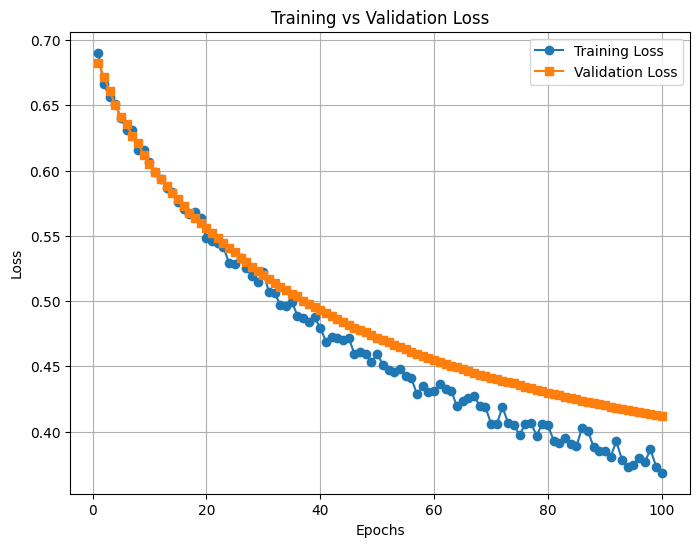

In [39]:
model = SentimentClassifier()
train_vectors = np.array([featurize_text(text) for text in train_texts])

max_vals, min_vals = findmaxmin(train_vectors)
train_vectors = normalize(max_vals, min_vals, train_vectors)

dev_vectors = np.array([featurize_text(text) for text in dev_texts])
dev_vectors = normalize(max_vals, min_vals, dev_vectors)

dev_labels_tensor = torch.tensor(dev_labels, dtype=torch.float32).view(-1, 1)
train_model(model, train_vectors, train_labels, dev_vectors, dev_labels_tensor, 100, 16, 0.1, True)

In [40]:
# Q7

def calculate_f1(model, vectors, labels):
    model.eval()
    with torch.no_grad():
        vectors_tensor = torch.tensor(vectors, dtype=torch.float32)
        preds = model(vectors_tensor)
        predicted_labels = [model.logprob2label(p) for p in preds]
        return f1(predicted_labels, labels)

f1_score_dev = calculate_f1(model, dev_vectors, dev_labels)
print(f"F1 Score on Dev Set: {f1_score_dev:.4f}")

F1 Score on Dev Set: 0.8947


In [41]:
test_vectors = np.array([featurize_text(text) for text in testtexts])
test_vectors = normalize(max_vals, min_vals, test_vectors)
f1_score_test = calculate_f1(model, test_vectors, testlabels)
print(f"F1 Score on Test Set: {f1_score_test:.4f}")

F1 Score on Test Set: 0.8679


Epoch 150/150
Avg train loss: 0.3368 | Validation loss: 0.3859
-----------------------------------------



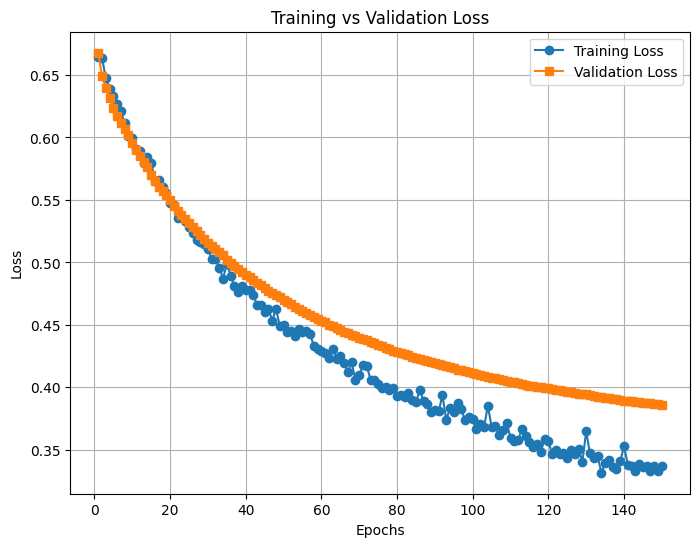


F1 Score on Dev Set: 0.8947

F1 Score on Test Set: 0.8679


Epoch 300/300
Avg train loss: 0.3361 | Validation loss: 0.3860
-----------------------------------------



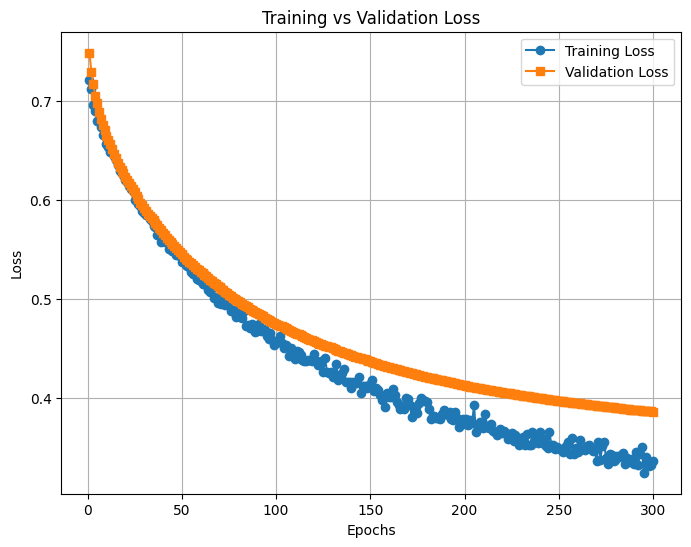


F1 Score on Dev Set: 0.8947

F1 Score on Test Set: 0.9020


Epoch 200/200
Avg train loss: 0.3908 | Validation loss: 0.4135
-----------------------------------------



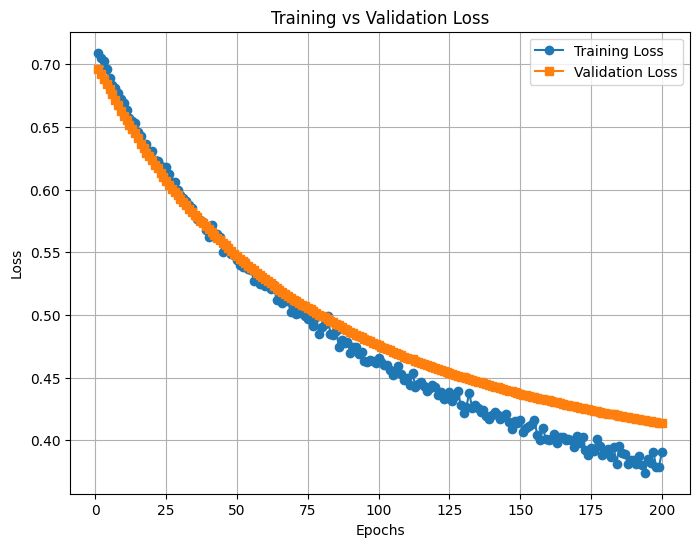


F1 Score on Dev Set: 0.8947

F1 Score on Test Set: 0.8846


Epoch 450/450
Avg train loss: 0.3901 | Validation loss: 0.4241
-----------------------------------------



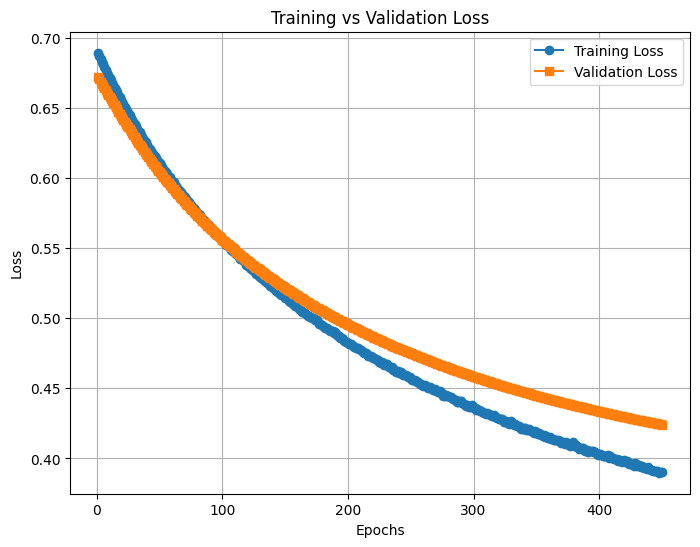


F1 Score on Dev Set: 0.8947

F1 Score on Test Set: 0.8679


Epoch 350/350
Avg train loss: 0.3476 | Validation loss: 0.3942
-----------------------------------------



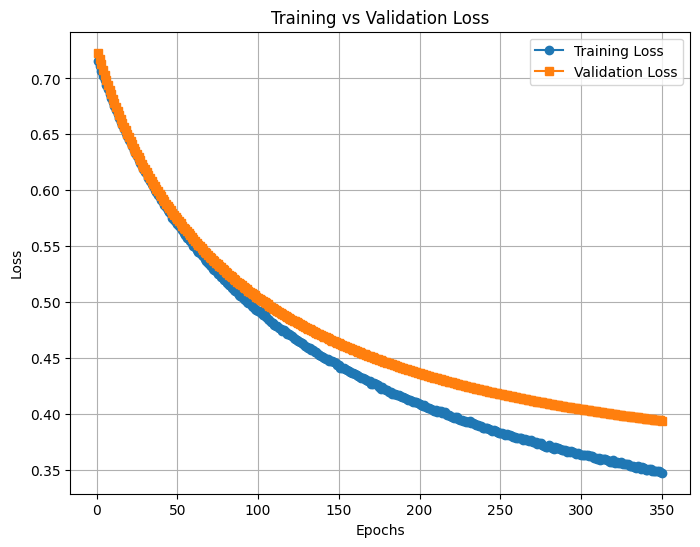


F1 Score on Dev Set: 0.8947

F1 Score on Test Set: 0.8846


Epoch 300/300
Avg train loss: 0.2726 | Validation loss: 0.3588
-----------------------------------------



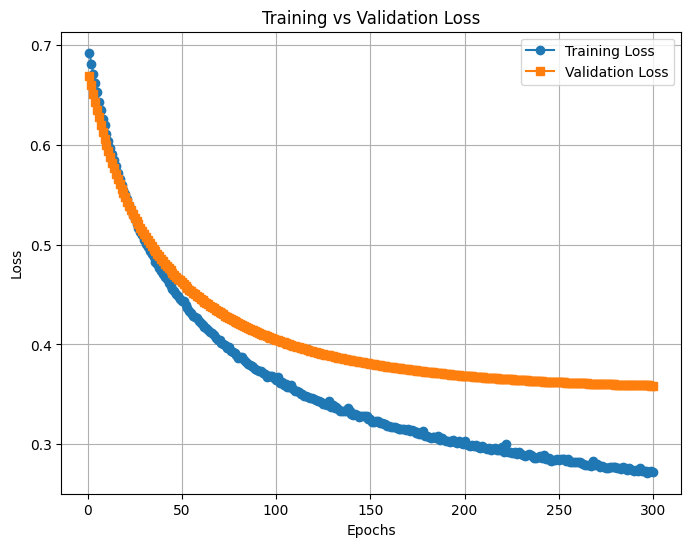


F1 Score on Dev Set: 0.8947

F1 Score on Test Set: 0.9020




In [42]:
# Q8 & Written Report Q1: Optimal Hyperparams Experiment

hyperparams = [
    (150, 0.1, 16),
    (300, 0.05, 16),
    (200, 0.05, 16),
    (450, 0.01, 8),
    (350, 0.02, 8),
    (300, 0.03, 4)
]

for num_epochs, learning_rate, batch_size in hyperparams:
  model = SentimentClassifier()
  train_model(model, train_vectors, train_labels, dev_vectors, dev_labels_tensor, num_epochs, batch_size, learning_rate, False)
  f1_score_dev = calculate_f1(model, dev_vectors, dev_labels)
  print(f"\nF1 Score on Dev Set: {f1_score_dev:.4f}\n")
  f1_score_test = calculate_f1(model, test_vectors, testlabels)
  print(f"F1 Score on Test Set: {f1_score_test:.4f}\n\n")

Epoch 300/300
Avg train loss: 0.2095 | Validation loss: 0.4835
-----------------------------------------



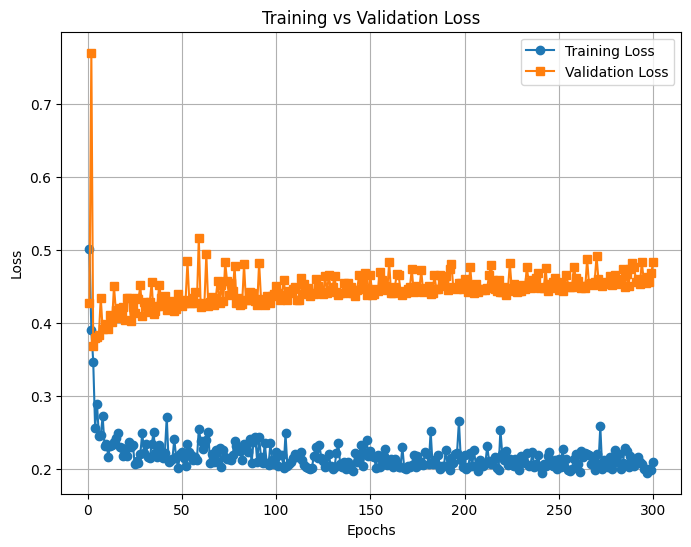

F1 Score on Dev Set: 0.8824
F1 Score on Test Set: 0.8936


In [44]:
# Written Report Q2: Training without normalization

model = SentimentClassifier()
train_vectors = np.array([featurize_text(text) for text in train_texts])

dev_vectors = np.array([featurize_text(text) for text in dev_texts])

dev_labels_tensor = torch.tensor(dev_labels, dtype=torch.float32).view(-1, 1)
train_model(model, train_vectors, train_labels, dev_vectors, dev_labels_tensor, 300, 16, 0.05, False)

f1_score_dev = calculate_f1(model, dev_vectors, dev_labels)
print(f"F1 Score on Dev Set: {f1_score_dev:.4f}")

test_vectors = np.array([featurize_text(text) for text in testtexts])

f1_score_test = calculate_f1(model, test_vectors, testlabels)
print(f"F1 Score on Test Set: {f1_score_test:.4f}")

Epoch 300/300
Avg train loss: 0.3366 | Validation loss: 0.3846
-----------------------------------------



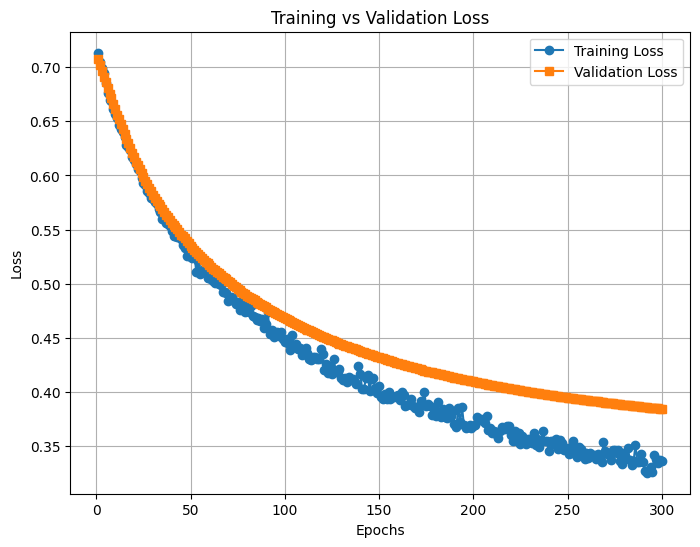

F1 Score on Dev Set: 0.8947
F1 Score on Test Set: 0.9020


In [48]:
# Written Report Q3: Remove a feature from the dataset and see its effect (Remove pronouns column)

class SentimentClassifier(torch.nn.Module):
    def __init__(self, input_dim: int = 5, output_size: int = 1):
        super(SentimentClassifier, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_size)

    def forward(self, feature_vec):
        z = self.linear(feature_vec)
        return torch.sigmoid(z)

    def logprob2label(self, log_prob):
        return log_prob.item() > 0.5

def new_featurize_text(text):
  vector = [0] * 5

  if len(text.split("!")) > 1:
    vector[3] = 1

  words = re.findall(r'\b[a-zA-Z]+\b', text)

  for word in words:
    if word.lower() in positive_words:
      vector[0] += 1
    if word.lower() in negative_words:
      vector[1] += 1
    if word.lower() == "no" and vector[2] == 0:
      vector[2] = 1

  vector[4] = math.log(len(words))
  return vector

model = SentimentClassifier()
train_vectors = np.array([new_featurize_text(text) for text in train_texts])

max_vals, min_vals = findmaxmin(train_vectors)
train_vectors = normalize(max_vals, min_vals, train_vectors)

dev_vectors = np.array([new_featurize_text(text) for text in dev_texts])
dev_vectors = normalize(max_vals, min_vals, dev_vectors)

dev_labels_tensor = torch.tensor(dev_labels, dtype=torch.float32).view(-1, 1)
train_model(model, train_vectors, train_labels, dev_vectors, dev_labels_tensor, 300, 16, 0.05, False)

f1_score_dev = calculate_f1(model, dev_vectors, dev_labels)
print(f"F1 Score on Dev Set: {f1_score_dev:.4f}")

test_vectors = np.array([new_featurize_text(text) for text in testtexts])
test_vectors = normalize(max_vals, min_vals, test_vectors)

f1_score_test = calculate_f1(model, test_vectors, testlabels)
print(f"F1 Score on Test Set: {f1_score_test:.4f}")